In [1]:
import os
import sys
import boto3
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from pathlib import Path
from dotenv import load_dotenv

# defining functions module path
module_path = str(Path.cwd().parents[0] / "src")
if module_path not in sys.path:
    sys.path.append(module_path)

from functions import connect_to_redshift

In [2]:
# removing warning messages
warnings.filterwarnings("ignore")

In [3]:
# Loading my .env file
load_dotenv()

True

In [4]:
# defining redshift credentials
dbname = os.getenv("dbname")
host = os.getenv("host")
port = os.getenv("port")
user = os.getenv("user")
password = os.getenv("password")

In [5]:
# establishing redshift connection
rs_connection = connect_to_redshift(dbname, host, port, user, password)

connection to redshift made


In [6]:
query = """select *
           from bootcamp.online_transactions_cleaned
        """

In [7]:
ot_cleaned = pd.read_sql(query, rs_connection)

In [8]:
ot_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 399841 entries, 0 to 399840
Data columns (total 9 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   invoice            399841 non-null  object        
 1   stock_code         399841 non-null  object        
 2   description        399841 non-null  object        
 3   price              399841 non-null  float64       
 4   quantity           399841 non-null  int64         
 5   total_order_value  399841 non-null  float64       
 6   invoice_date       399841 non-null  datetime64[ns]
 7   customer_id        399841 non-null  object        
 8   country            399841 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(5)
memory usage: 27.5+ MB


In [9]:
ot_cleaned.describe()

,price,quantity,total_order_value
count,399841.000000,399841.000000,399841.000000
mean,2.952914,12.224359,20.716904
std,7.317593,250.788860,425.471765
min,0.000000,-80995.000000,-168469.600000
25%,1.250000,2.000000,4.250000
50%,1.950000,5.000000,11.580000
75%,3.750000,12.000000,19.500000
max,1599.260000,80995.000000,168469.600000


In [10]:
no_price_stock = ot_cleaned[ot_cleaned.price <= 0]['stock_code'].unique()
print(f"There are {ot_cleaned[ot_cleaned.price <= 0].shape[0]} transactions with price equal to zero")
ot_cleaned[ot_cleaned['stock_code'].isin(no_price_stock)]

There are 34 transactions with price equal to zero


,invoice,stock_code,description,price,quantity,total_order_value,invoice_date,customer_id,country
60,C536548,22580,ADVENT CALENDAR GINGHAM SACK,5.95,-4,-23.80,2010-12-01 14:33:00,u12472,Germany
98,536464,22619,SET OF 6 SOLDIER SKITTLES,3.75,1,3.75,2010-12-01 12:23:00,u17968,United Kingdom
115,536667,22423,REGENCY CAKESTAND 3 TIER,12.75,4,51.00,2010-12-02 12:09:00,u1526,United Kingdom
144,536947,22423,REGENCY CAKESTAND 3 TIER,12.75,3,38.25,2010-12-03 12:29:00,u13013,United Kingdom
251,537201,22636,CHILDS BREAKFAST SET CIRCUS PARADE,8.50,4,34.00,2010-12-05 14:19:00,u12472,Germany
...,...,...,...,...,...,...,...,...,...
399335,581230,22090,PAPER BUNTING RETROSPOT,2.95,12,35.40,2011-12-08 10:24:00,u14291,United Kingdom
399369,579149,22619,SET OF 6 SOLDIER SKITTLES,3.75,4,15.00,2011-11-28 13:21:00,u13844,United Kingdom
399384,579165,22619,SET OF 6 SOLDIER SKITTLES,3.75,4,15.00,2011-11-28 14:01:00,u13389,United Kingdom
399579,580536,22619,SET OF 6 SOLDIER SKITTLES,3.75,4,15.00,2011-12-04 16:07:00,u1249,France


### Even though there are some transactions with stocks with price equal to zero, they having been also purchases with the same stocks having price bigger than 0. What happened there?

In [11]:
no_price = ot_cleaned[ot_cleaned.price <= 0]

In [12]:
print(f"There are {(ot_cleaned.quantity < 0).sum()} entries with negative quantity")

There are 8507 entries with negative quantity


In [13]:
ot_cleaned['invoice'][ot_cleaned.quantity < 0]

60        C536548
139       C536820
150       C536548
205       C536850
252       C536807
           ...   
399631    C580968
399708    C581464
399729    C581464
399753    C580711
399834    C581462
Name: invoice, Length: 8507, dtype: object

### The total order value is equal to price * quantity, therefore the negavite values in this column

In [14]:
# Checking is all the invoice with negative quantity start with a letter C 
ot_cleaned['invoice'][ot_cleaned.quantity < 0].str.startswith('C').sum()

8507

### I will consider all the entries with negative quantity as returns. They have a C in the invoice code, which I will assume refers to a CANCELLED transaction

In [15]:
ot_cancelled = ot_cleaned[ot_cleaned.invoice.str.startswith('C')]

### I will clean my ot_cleaned by removing the transactions with negative quantity and the transactions with price equal to zero

In [16]:
# Dropping cancelled orders
ot_cleaned.drop(ot_cancelled.index, axis=0, inplace=True)

In [17]:
# Dropping transaction with no price
ot_cleaned.drop(no_price.index, axis=0, inplace=True)

In [18]:
ot_cleaned.describe(include=object)

,invoice,stock_code,description,customer_id,country
count,391300,391300,391300,391300,391300
unique,18405,3662,3627,4334,37
top,576339,85123A,CREAM HANGING HEART T-LIGHT HOLDER,u17841,United Kingdom
freq,542,2023,2023,7667,348919


### The number of unique descriptions is not compatible with the number of unique stock codes. Why?

In [32]:
# Getting the data grouped by description and unique stock_code
descr_group = ot_cleaned.groupby('description').agg({'stock_code': 'unique'})


# Filtering just the descriptions with more than one stock_code
descr_group[ot_cleaned.groupby('description').agg({'stock_code': 'nunique'}).values!=1]

,stock_code
description,
COLOURING PENCILS BROWN TUBE,"[10135, 10133]"
COLUMBIAN CANDLE RECTANGLE,"[72133, 72131]"
COLUMBIAN CANDLE ROUND,"[72130, 72128]"
EAU DE NILE JEWELLED PHOTOFRAME,"[85023B, 85024B]"
FRENCH FLORAL CUSHION COVER,"[20840, 20837]"
FRENCH LATTICE CUSHION COVER,"[20838, 20835]"
FROSTED WHITE BASE,"[79403, 79406]"
"METAL SIGN,CUPCAKE SINGLE HOOK","[82613B, 82613C, 82613A]"
PINK FAIRY CAKE CUSHION COVER,"[47586A, 47585A]"


### It is interesting to see that there are some stock codes with 'Unknown' description. Concerning the descriptions with more than one stock code, I will infer that they are the same product on different presentations (i.e size)

In [25]:
# Filtering the data to get the number of stock codes with 'Unknown' description
stock_code_unknown = ot_cleaned[ot_cleaned.description == 'Unknown']['stock_code'].unique()
print(f"There are {stock_code_unknown.shape[0]} stock codes with unknown description")

There are 18 stock codes with unknown description


In [26]:
# Checking if the stock codes with unknown description were sold in all countries
ot_cleaned[ot_cleaned['stock_code'].isin(stock_code_unknown)].country.unique()

array(['United Kingdom', 'Belgium', 'Switzerland', 'France',
       'Unspecified', 'EIRE', 'Poland', 'Germany', 'Spain', 'Norway',
       'Singapore', 'Sweden', 'Austria', 'Canada', 'Italy'], dtype=object)

### The Unknown description purchases were made across 15 of the 37 countries. The reason why they are Unknown is still unclear

### Let's explore each column

In [19]:
print(f"The data contains information about 391334 ({ot_cleaned.invoice.nunique()} invoices in total) online purchases made from {ot_cleaned.invoice_date.min()} to {ot_cleaned.invoice_date.max()}. {ot_cancelled.shape[0]} are cancelled orders")

The data contains information about 391334 (18405 invoices in total) online purchases made from 2010-12-01 08:26:00 to 2011-12-09 12:50:00. 8507 are cancelled orders


In [20]:
print(f"A total of {ot_cleaned.stock_code.nunique()} stock codes were sold from which {ot_cancelled.stock_code.nunique()} stocks were return at least once")

A total of 3662 stock codes were sold from which 1916 stocks were return at least once


In [21]:
inv_country = ot_cleaned.groupby('country').count()['invoice'].sort_values(ascending=False)

In [22]:
print(f"The invoices were purchased in 37 countries being {inv_country.index[0]} the country with the most purchases ({inv_country[0]}) and {inv_country.index[-1]} with the least ({inv_country[-1]})")

The invoices were purchased in 37 countries being United Kingdom the country with the most purchases (348919) and Saudi Arabia with the least (9)


In [23]:
print(f"In total, there are {ot_cleaned.customer_id.nunique()} costumers")

In total, there are 4334 costumers


In [27]:
print(f"There are {ot_cleaned.description.nunique()} stock descriptions. These are less than stock codes ({ot_cleaned.stock_code.nunique() - ot_cleaned.description.nunique()}). Which means that there are some stock codes without descriptions. Let's explore that field")

There are 3627 stock descriptions. These are less than stock codes (35). Which means that there are some stock codes without descriptions. Let's explore that field


### Let's check the box plot of the numerical variables

<Axes: >

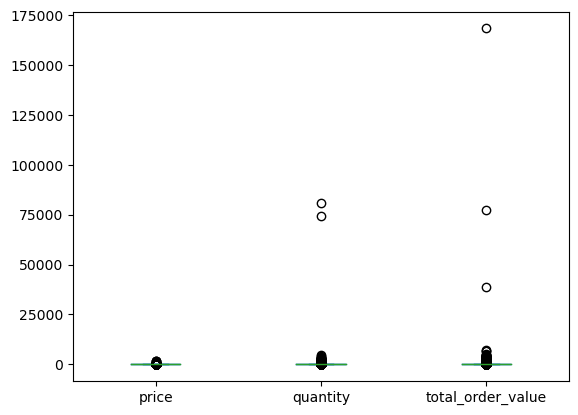

In [49]:
ot_cleaned.plot.box()

### The are clear outliers in all of them. Let's use the IQR method to explore a bit further

In [119]:
# Let's start by exploring the outliers in the price column
_, mean_price, std_price, min_price, Q1_price, Q2_price, Q3_price, max_price = ot_cleaned.price.describe()
IQR_price = Q3_price - Q1_price
low_lim_price = Q1_price - 1.5 * IQR_price
up_lim_price = Q3_price + 1.5 * IQR_price

Text(0.5, 23.52222222222222, 'Price (pounds)')

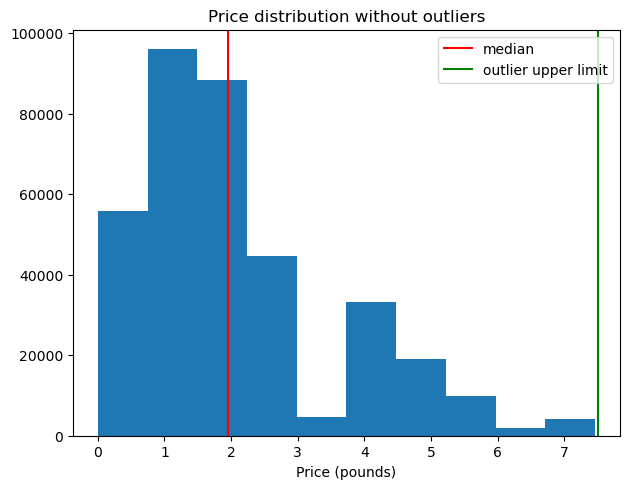

In [111]:
# Price histogram plotting
plt.hist(ot_cleaned.price[ot_cleaned['price'] < up_lim_price])
plt.axvline(x=Q2_price, color='red', label='median')
plt.axvline(x=up_lim_price, color='green', label='outlier upper limit')
plt.title("Price distribution without outliers")
plt.legend(loc='upper right')
plt.tight_layout()
plt.xlabel('Price (pounds)')

In [117]:
n_outliers = ot_cleaned.price[ot_cleaned['price'] > up_lim_price].shape[0] * 100 / ot_cleaned.shape[0]
print(f"A total of {round(n_outliers, 2)} % of the data was identify as outlier")a

A total of 8.42 % of the data was identify as outlier


### In the table below are shown the top 10 stock codes sold, their description, amount sold, their price and in how many country they had been sold

In [30]:
# Let's get top 10 stock codes on the table 
top10 = ot_cleaned.groupby("stock_code").agg({'description': 'first', 'quantity': 'sum', 'price': 'first', 'country': 'nunique'}).sort_values(by='quantity', ascending=False)[:10]
top10

,description,quantity,price,country
stock_code,,,,
23843,"PAPER CRAFT , LITTLE BIRDIE",80995,2.08,1
23166,MEDIUM CERAMIC TOP STORAGE JAR,77916,1.25,10
84077,WORLD WAR 2 GLIDERS ASSTD DESIGNS,54319,0.29,12
22197,POPCORN HOLDER,49160,0.85,14
85099B,JUMBO BAG RED RETROSPOT,46078,1.95,20
85123A,CREAM HANGING HEART T-LIGHT HOLDER,36763,2.95,16
84879,ASSORTED COLOUR BIRD ORNAMENT,35263,1.69,16
21212,PACK OF 72 RETROSPOT CAKE CASES,33670,0.42,20
23084,RABBIT NIGHT LIGHT,27153,2.08,19


### On the other hand, we can also inspect the top 10 for each contry. Let's see which stock

In [31]:
for country in ot_cleaned.country.unique():
    country_idx = ot_cleaned['country'] == country
    top10_country = ot_cleaned[country_idx].groupby("stock_code").agg({'description': 'first', 'quantity': 'sum', 'price': 'first'}).sort_values(by='quantity', ascending=False)
    print(country)
    print(top10_country[:10],"\n")

United Kingdom
                                   description  quantity  price
stock_code                                                     
23843              PAPER CRAFT , LITTLE BIRDIE     80995   2.08
23166           MEDIUM CERAMIC TOP STORAGE JAR     76919   1.25
84077        WORLD WAR 2 GLIDERS ASSTD DESIGNS     49086   0.29
22197                           POPCORN HOLDER     45609   0.85
85099B                 JUMBO BAG RED RETROSPOT     41878   1.95
85123A      CREAM HANGING HEART T-LIGHT HOLDER     34687   2.95
84879            ASSORTED COLOUR BIRD ORNAMENT     32628   1.69
22616               PACK OF 12 LONDON TISSUES      24321   0.29
17003                      BROCADE RING PURSE      22675   0.21
21212          PACK OF 72 RETROSPOT CAKE CASES     22442   0.42 

Australia
                              description  quantity  price
stock_code                                                
22492             MINI PAINT SET VINTAGE       2952   0.55
23084                  RABBI